### Выполнил студент Благоразумов Александр Сергеевич группы ББМО-01-23

### 1. Загрузка обученной модели и данных MNIST

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(_, _), (test_images, test_labels) = mnist.load_data()

test_images = test_images / 255.0

test_labels = to_categorical(test_labels, num_classes=10)

model = tf.keras.models.load_model('mnist_model.h5')

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9736 - loss: 0.0923
Test accuracy on clean images: 0.9772999882698059


### 2. Реализация атаки PGD с использованием Foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.6 MB/s eta 0:00:00


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


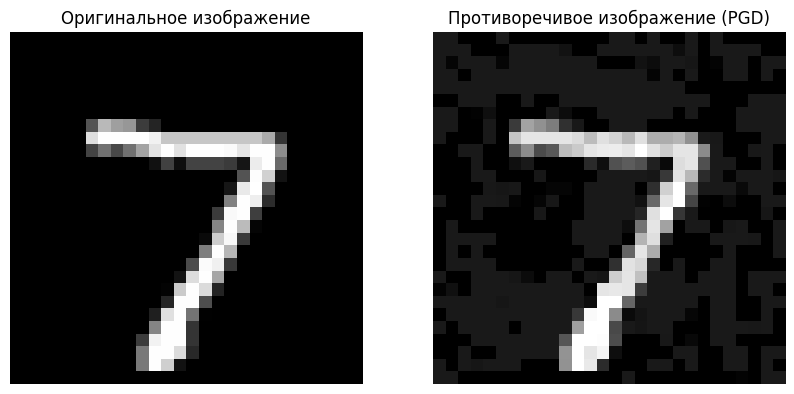

In [3]:
!pip install foolbox
import torch
import torch.nn as nn
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Выбор изображения для атаки
image = tf.convert_to_tensor(test_images[0], dtype=tf.float32)[None, ...]
label = np.argmax(test_labels[0])
label = tf.convert_to_tensor(label, dtype=tf.int64)

# Выполнение атаки
attack = fb.attacks.LinfPGD()
advs, _, success = attack(fmodel, image, label[None], epsilons=0.1)

# Вывод оригинального и противоречивого изображения
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (PGD)")
plt.imshow(advs[0].numpy(), cmap="gray")
plt.axis('off')

plt.show()

### 3. Оценка модели на противоречивых примерах

In [9]:
# Параметры для теста
num_images = 100  # Ограничение на количество изображений
batch_size = 10   # Размер мини-пакета

# Убедитесь, что test_images и test_labels содержат достаточно данных
test_images = test_images[:num_images]
test_labels = test_labels[:num_images]

# Контейнер для атакованных изображений
adversarial_images = []

# Обработка изображений по мини-пакетам
for i in range(0, len(test_images), batch_size):
    # Формируем мини-пакет изображений и меток
    images_batch = tf.convert_to_tensor(test_images[i:i+batch_size], dtype=tf.float32)
    labels_batch = np.argmax(test_labels[i:i+batch_size], axis=1)
    labels_batch = tf.convert_to_tensor(labels_batch, dtype=tf.int64)

    # Применяем атаку ко всему мини-пакету
    advs_batch, _, success = attack(fmodel, images_batch, labels_batch, epsilons=0.01)
    adversarial_images.append(advs_batch)

# Конвертация списка в массив тензоров
adversarial_images = tf.concat(adversarial_images, axis=0)

# Убедитесь, что test_labels имеют соответствующее количество меток
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[:num_images])
print(f'Accuracy on adversarial examples (PGD attack): {adversarial_acc}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0270 
Accuracy on adversarial examples (PGD attack): 1.0


### Вывод

По итогам проделанной работы мы можем сделать вывод о том, что модель имеет высокую уязвимость к атакам типа PGD (Projected Gradient Descent). Изначальная точность в 97% говорит о том, что модель хорошо справляется с тестовыми данными при нормальных условиях. Но мы можем наблюдать резкое снижение точности после применения атаки PGD, которое свидетельствует нам о том, что модель не устойчива к небольшим, но целенаправленным изменениям входных данных, которые могут быть эффективно использованы для введения в заблуждение модели.